## CTD Transect Report, Lake Zug, 07.01.2026

In [1]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import json
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime
import warnings; warnings.filterwarnings('ignore')
#%matplotlib qt
%matplotlib inline

c:\Users\herremha\AppData\Local\anaconda3\envs\ewg\Lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260107'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

#### Lake map

Profiles overlayed on bathymetry and transect depths.

In [265]:
def extract_profile_locations(dpath_L1, oom=True):
    profile_locs = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(serial_id, lake, year, date, fpath)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # Swiss coordinates
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)

        # bathymetry
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()
        
        profile_locs.append({
            'name': ds.attrs['Profile name'],
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(profile_locs).sort_values('ysc', ascending=False).reset_index(drop=True), bathy

In [266]:
profile_locs, bathy = extract_profile_locations(dpath_L1)

In [423]:
def plot_profiles_map_bathy(profile_locs, bathy):
    # don't doule plot duplicates
    profile_locs = profile_locs.drop_duplicates(subset='name')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), width_ratios=[1.2, 1])

    # map
    im = ax[0].pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
    cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', location='left', pad=0.13, ax=ax[0])
    cbar.ax.invert_yaxis()

    # bathymetry
    sns.lineplot(profile_locs, x='ysc', y='total_depth', marker='o', ax=ax[1])
    
    # profile locations
    for _, p in profile_locs.iterrows():
        ax[0].scatter(p['xsc'], p['ysc'], c='steelblue', edgecolor='black', marker='o')
        ax[0].annotate(p['name'], (p['xsc'], p['ysc']), color='red', xytext=(3,0), textcoords='offset points')
        ax[1].annotate(p['name'], (p['ysc'], p['total_depth']), color='red', xytext=(0,5), textcoords='offset points')
        

    ax[1].set_xlabel('Y Swiss Coordinate')
    ax[1].set_ylabel('Depth [m]')

    ax[1].set_ylim(0, 205)
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].spines[['right', 'top']].set_visible(False)

    plt.tight_layout(w_pad=2)
    plt.show()

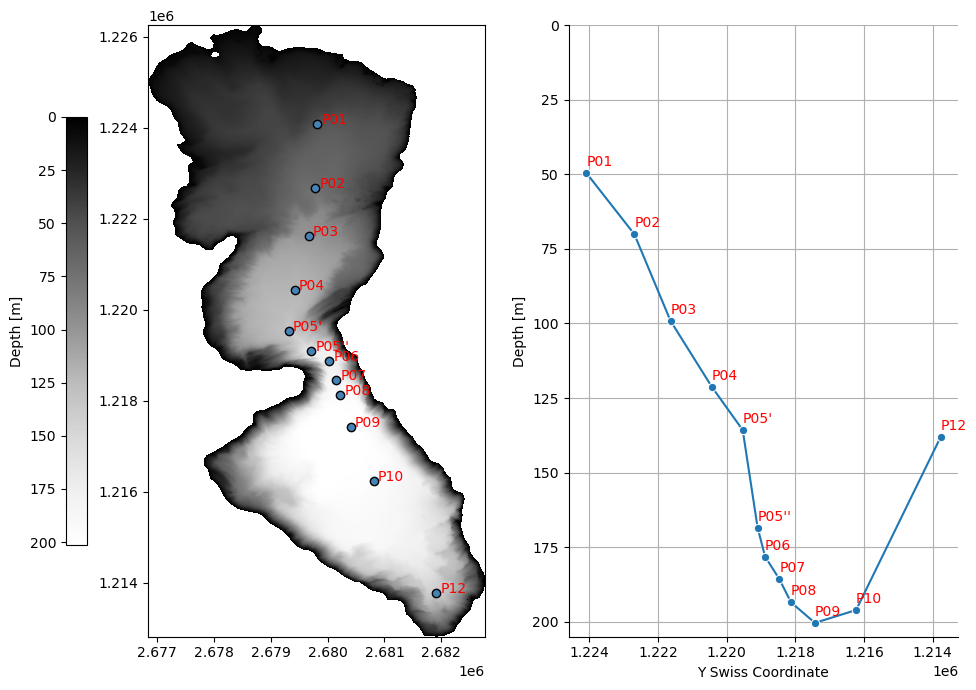

In [424]:
plot_profiles_map_bathy(profile_locs, bathy)

#### Fall speed

L1 .nc files only have minute precision for time, can't calculate fall speed.

#### Temperature/Oxygen transect

In [425]:
def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(serial_id, lake, year, date, fpath)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)

In [426]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')

In [460]:
def plot_profiles_transect(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(df['time'].unique()), figsize=(15, 5), sharex=True, sharey=True)
    if var == 'Temp':
        color = 'steelblue'
    elif var == 'DO_mg':
        color = 'green'

    for i, (t, dat) in enumerate(df.groupby('time', sort=False)):
        ax[i].plot(dat[var], dat['depth'], color=color)
        ax[i].axhline(dat['total_depth'].unique()[0], color='gray', ls='--')

        ax[i].set_title(dat['name'].unique()[0])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()

    if var == 'Temp':
        fig.supxlabel('Temperature [°C]')
    elif var == 'DO_mg':
        fig.supxlabel('Dissolved Oxygen Concentration [mg/L]')

    plt.tight_layout(w_pad=0.5)
    plt.show()

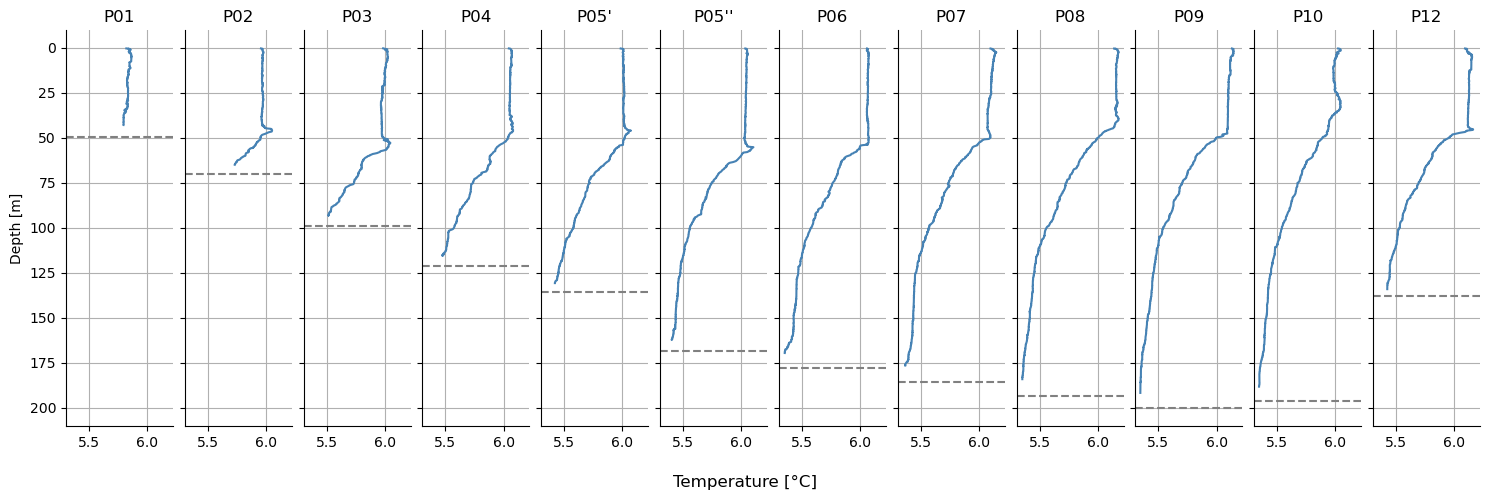

In [458]:
plot_profiles_transect(temp_data, 'Temp', '11:30')

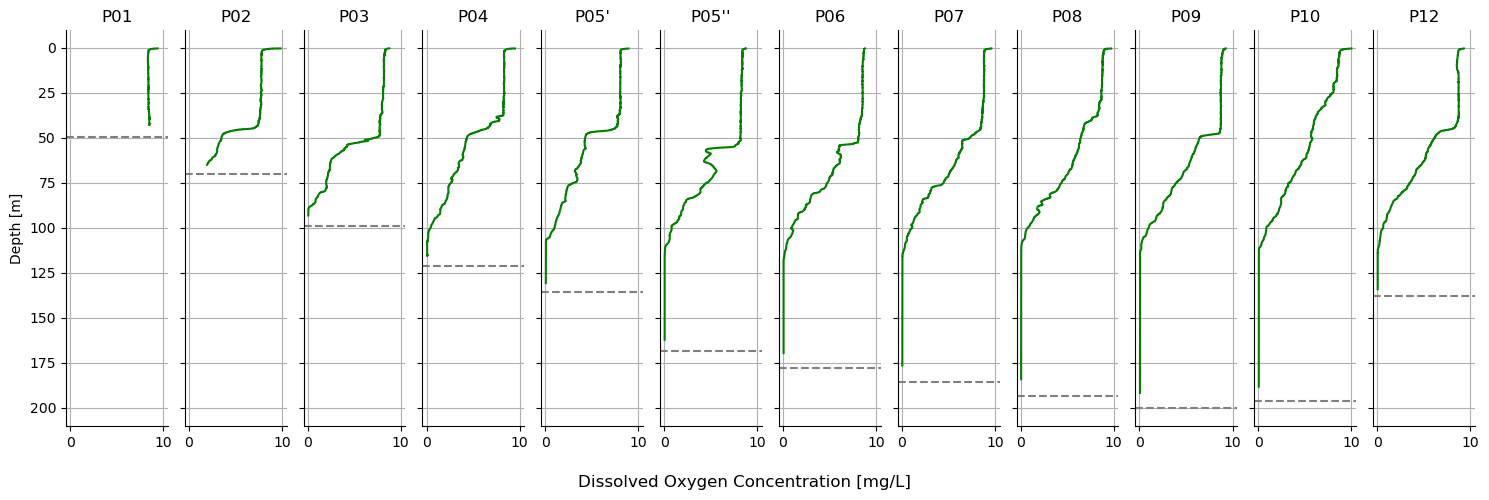

In [459]:
plot_profiles_transect(do_data, 'DO_mg', '11:30')

#### Temperature/Oxygen repeated location

In [445]:
def plot_profiles_overlay(data, var, locs):
    df = data[data['name'].isin(locs)]

    fig, ax = plt.subplots(figsize=(7, 5))

    for t, dat in df.groupby('time', sort=False):
        ax.plot(dat[var], dat['depth'], label=f"{dat['name'].unique()[0]} | {t}")

    if var == 'Temp':
        ax.set_xlabel('Temperature [°C]')
    elif var == 'DO_mg':
        ax.set_xlabel('Dissolved Oxygen Concentration [mg/L]')
    ax.set_ylabel('Depth [m]')
    ax.set_title(f'Profile Locations {locs}')

    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)
    ax.legend()
    ax.invert_yaxis()

    plt.show()

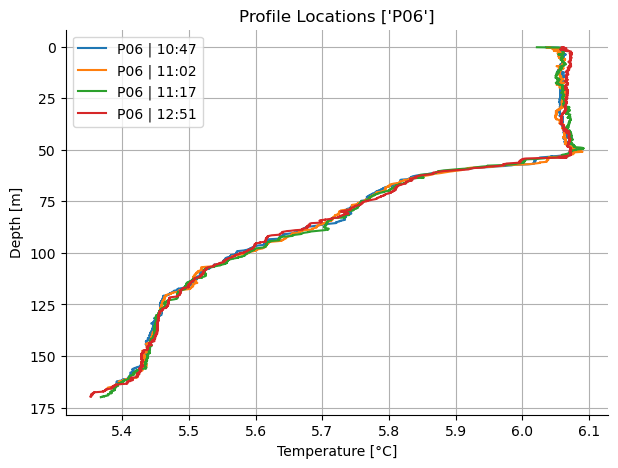

In [446]:
plot_profiles_overlay(temp_data, 'Temp', ['P06'])

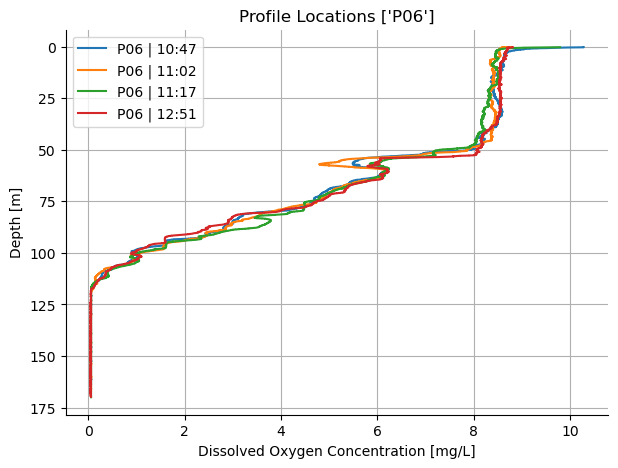

In [447]:
plot_profiles_overlay(do_data, 'DO_mg', ['P06'])

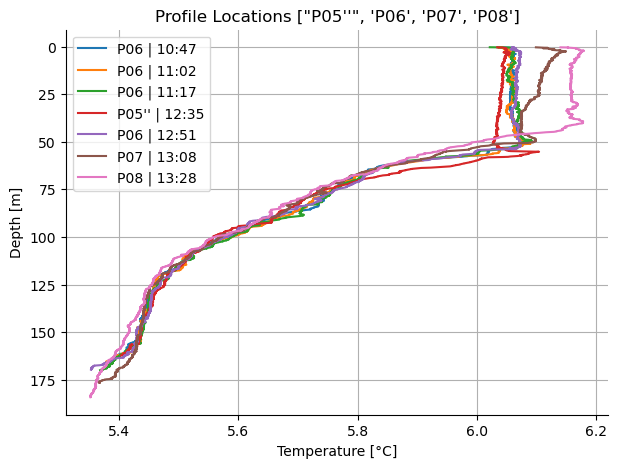

In [448]:
plot_profiles_overlay(temp_data, 'Temp', ["P05''", "P06", "P07", "P08"])

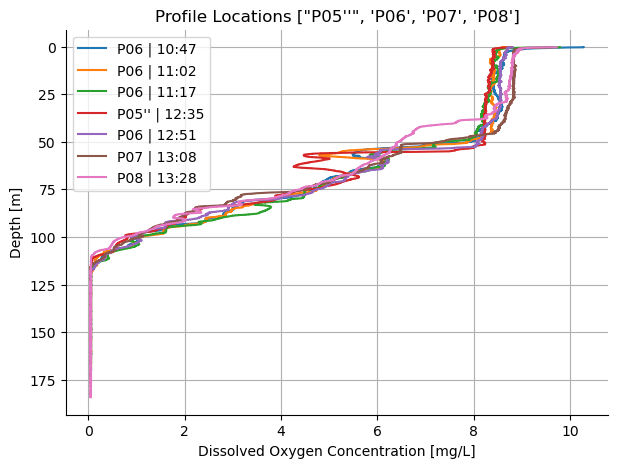

In [449]:
plot_profiles_overlay(do_data, 'DO_mg', ["P05''", "P06", "P07", "P08"])

#### Isotherms/Isopycnals

In [451]:
def calculate_isolines(dpath_L1, var, isovals, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(serial_id, lake, year, date, fpath)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'Temp':
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        elif var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask] 

        for iv in isovals:
            try:
                if var == 'Temp':
                    idxl = np.where(vals < iv)[0][0]
                    idxu = np.where(vals > iv)[0][-1]
                elif var == 'rho':
                    idxl = np.where(vals > iv)[0][0]
                    idxu = np.where(vals < iv)[0][-1]

                idx = round((idxl + idxu)/2)
                z = depth[idx].item()
            except IndexError:
                z = np.nan

            data.append({
                'var': var,
                'iso_val': iv,
                'iso_z': z,
                'name': name,
                'time': time,
                'xsc': xsc,
                'ysc': ysc,
                'total_depth': total_depth
            })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)

In [470]:
isotherm_data = calculate_isolines(dpath_L1, 'Temp', [6.0, 5.9, 5.8, 5.7, 5.6, 5.5, 5.4])
isopycnal_data = calculate_isolines(dpath_L1, 'rho', np.array([0.13, 0.14, 0.15, 0.16, 0.17]) + 1000)

In [471]:
def plot_isolines(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))
    order = np.sort(df['iso_val'].unique())
    if var == 'Temp':
        palette = sns.color_palette('Blues_d', n_colors=len(order))[::-1]
    elif var == 'rho':
        palette = sns.color_palette('Oranges_d', n_colors=len(order))

    sns.lineplot(df, x='ysc', y='iso_z', hue='iso_val', hue_order=order, palette=palette, marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)

    if var == 'Temp':
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='Temperature [°C]')
    elif var == 'rho':
        ax.legend(title='Density [kg/m3]')
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

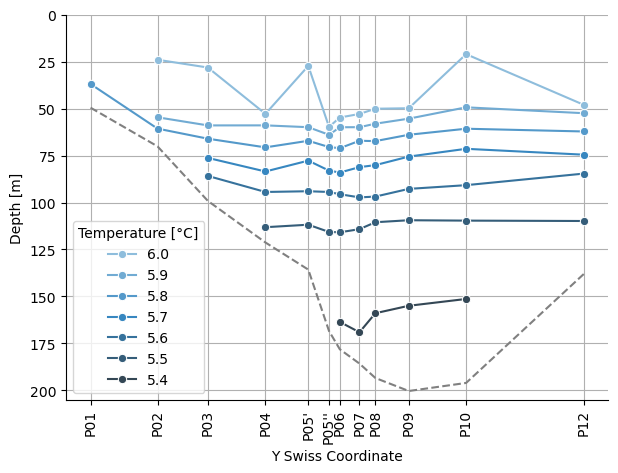

In [472]:
plot_isolines(isotherm_data, 'Temp', t_start='11:30')

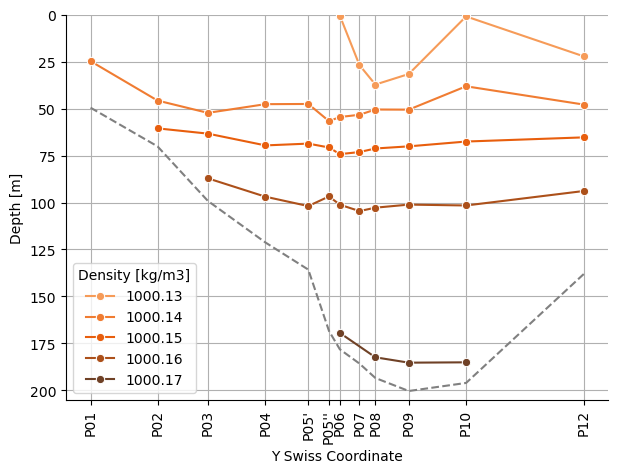

In [473]:
plot_isolines(isopycnal_data, 'rho', t_start='11:30')

#### Anoxic region

In [485]:
def calculate_transect_min_do(dpath_L1):
    # transect minimum
    min_do = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(serial_id, lake, year, date, fpath)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        do = ds['DO_mg'][mask]
        min_do.append(do.min().item())

    return min(min_do)


def calculate_anoxia(dpath_L1, err=0.2, oom=True):
    min_do = calculate_transect_min_do(dpath_L1)

    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(serial_id, lake, year, date, fpath)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        depth = ds['depth'][mask]
        do = ds['DO_mg'][mask]

        try:
            idx = np.where(do <= min_do + err)[0][0]
            z = depth[idx].item()
        except IndexError:
            z = np.nan

        data.append({
            'anoxic_z': z,
            'name': name,
            'time': time,
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)


In [486]:
anoxic_data = calculate_anoxia(dpath_L1)

In [493]:
def plot_anoxia(data, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.lineplot(df, x='ysc', y='anoxic_z', color='limegreen', marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_title('Anoxic Zone')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

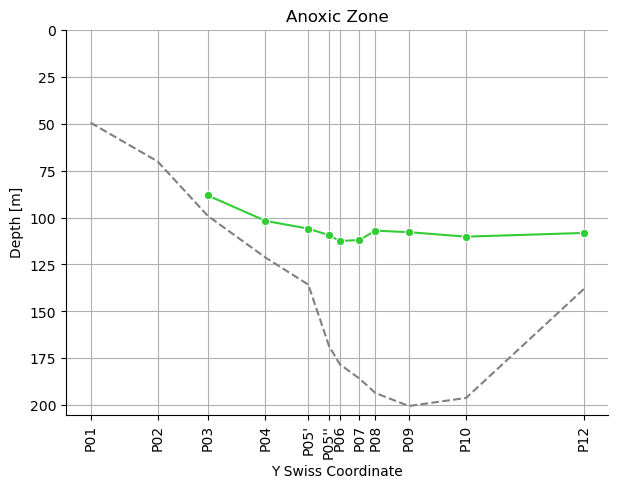

In [494]:
plot_anoxia(anoxic_data, t_start='11:30')

### Workspace

In [25]:
dpath = 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/CTD/20260107/L0'

# Lake Zug bathymetry
bathy = xr.open_dataset('../../../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

In [7]:
def locate_files(dpath, ext='TOB'):
    md_files = glob(os.path.join(dpath, '*.meta'))

    profiles = []
    for mdf in md_files:
        fpath, _ = os.path.splitext(mdf)
        profiles.append(f'{fpath}.{ext}')

    return md_files, profiles

In [8]:
md_files, profiles = locate_files(dpath)

In [124]:
def parse_profiles_sea_and_sun(md_files, profiles, bathy):
    data = {}
    for md_file, profile in tqdm(zip(md_files, profiles)):
        with open(md_file, 'r') as f:
            md = json.load(f)

        time = md['profile']['Time of measurement (local)']
        xsc = int(md['profile']['X Coordinate (CH1903)']) + int(2e6)
        ysc = int(md['profile']['Y Coordinate (CH1903)']) + int(1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        with open(profile, encoding='latin1', errors='ignore') as f:
            lines = f.readlines()

        for l in range(len(lines)):
            if "Lines :" in lines[l]:
                break

        columns = lines[l + 2].replace(";", "").split()[1:]
        df = pd.read_csv(profile, sep='\s+', header=None, skiprows=l+5, names=columns, engine='python', encoding='cp1252')

        # select downcast
        bottom_idx = np.argmax(df['Press'])
        df = df[:bottom_idx]

        # remove air
        df = df[df['Press'] > 1]

        # fall speed
        df['time']= pd.to_timedelta(df["IntT"])
        df["t_sec"] = (df['time'] - df['time'].iloc[0]).dt.total_seconds()
        df['fall_speed'] = np.gradient(df['Press'], df['t_sec'])

        data[time] = {
            'name': md['profile']['Profile name'],
            'xsc': xsc,
            'ysc': ysc,
            'press': df['Press'].values, 
            'temp': df['Temp'].values,
            'd_oxygen_conc': df['DO_mg'].values * (1000/32),
            'fall_speed': df['fall_speed'].values,
            'total_depth': total_depth
        }

    # sort by time
    return dict(sorted(data.items()))

In [125]:
data = parse_profiles_sea_and_sun(md_files, profiles, bathy)

0it [00:00, ?it/s]

In [126]:
def plot_profiles(data, dp, var, color):
    ncols = len([t for t in data.keys() if t > '11:17'])
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5), sharex=True, sharey=True)

    i = 0
    for t, dat in data.items():
        if t > '11:17':
            ax[i].plot(dat[var], dat[dp], c=color)
            ax[i].set_title(dat['name'])

            if dp == 'depth':
                ax[i].axhline(dat['total_depth'], color='gray', linestyle='--')
            
            ax[i].spines[['right', 'top']].set_visible(False)
            ax[i].grid(True)

            i += 1

    if dp == 'depth':
        ax[0].set_ylabel('Depth (m)')
    elif dp == 'press':
        ax[0].set_ylabel('Pressure (dbar)')

    if var == 'temp':
        fig.supxlabel('Temperature (°C)')
    elif var == 'd_oxygen_conc':
        fig.supxlabel('Dissolved Oxygen Concentration (umol/L)')
    elif var == 'fall_speed':
        fig.supxlabel('Fall Speed [dbar/s]')

    ax[0].invert_yaxis()

    plt.tight_layout()
    plt.show()

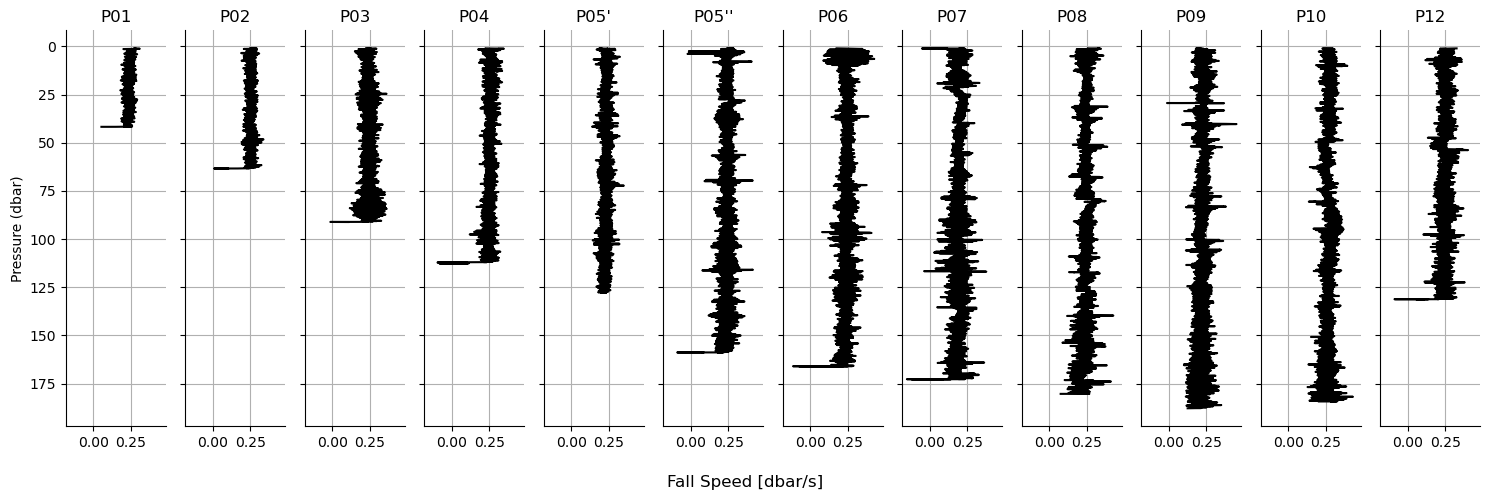

In [127]:
plot_profiles(data, 'press', 'fall_speed', 'black')

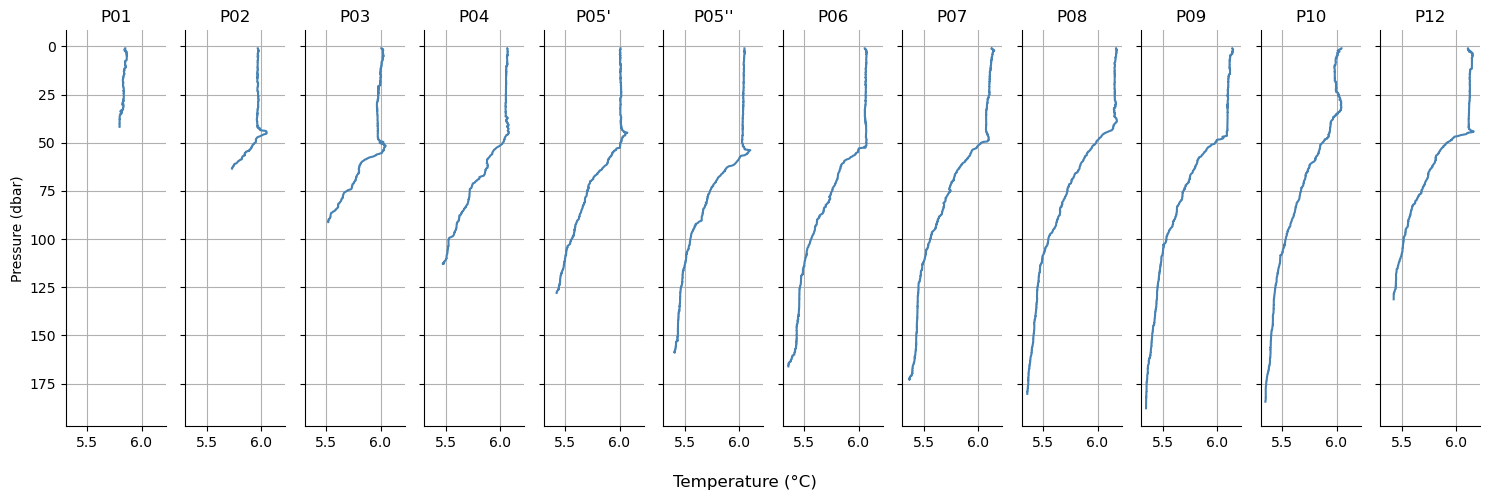

In [81]:
plot_profiles(data, 'press', 'temp', 'steelblue')

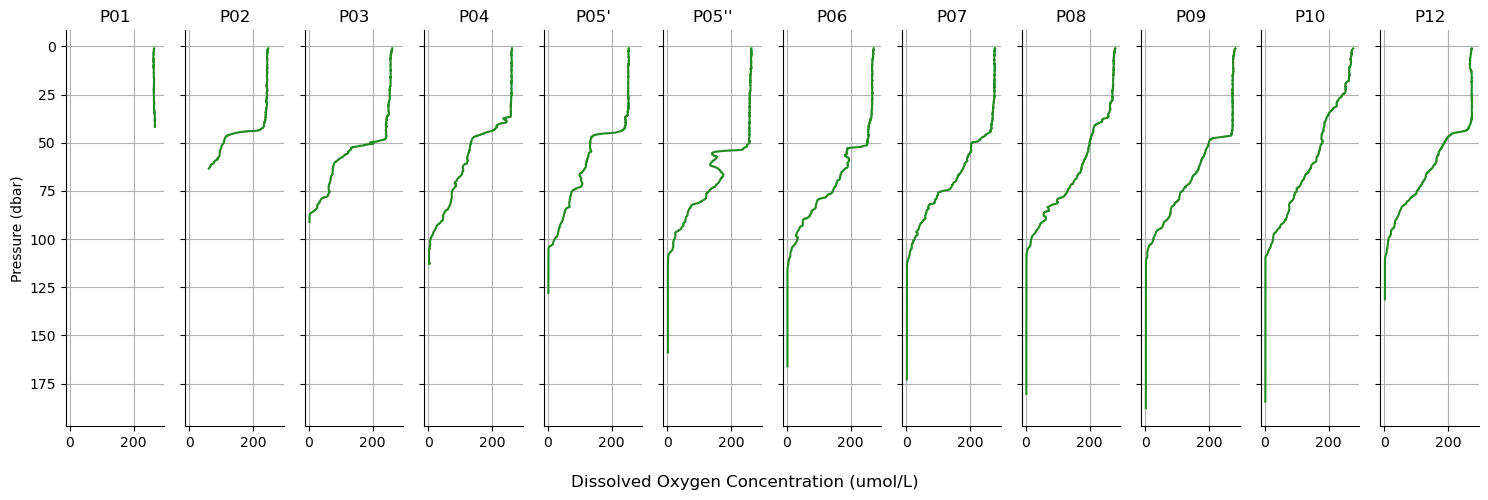

In [83]:
plot_profiles(data, 'press', 'd_oxygen_conc', 'forestgreen')

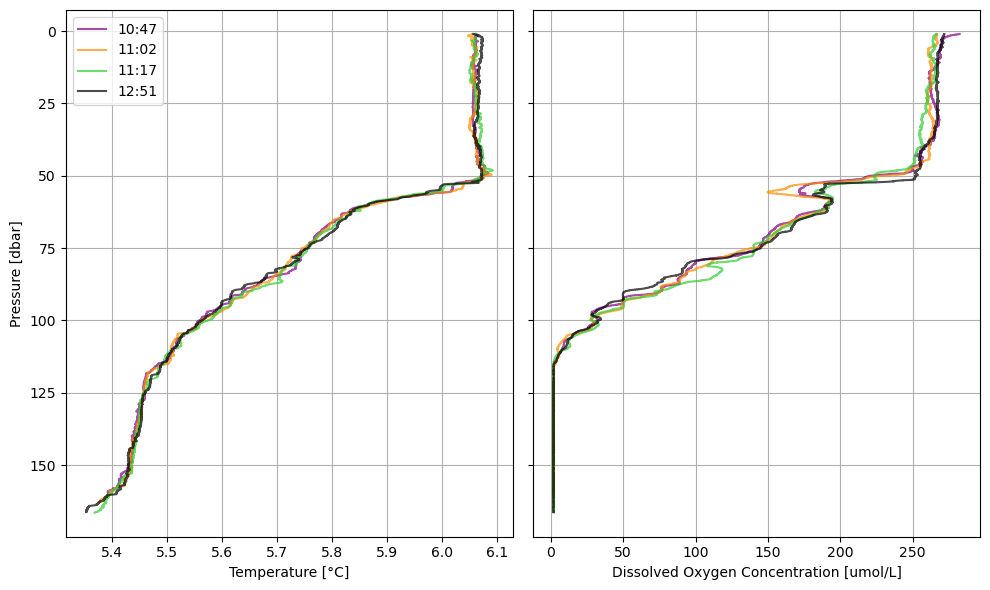

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)
palette = ['purple', 'darkorange', 'limegreen', 'black']

i = 0
for t, dat in data.items():
    if dat['name'] == 'P06':
        ax[0].plot(dat['temp'], dat['press'], color=palette[i], alpha=0.7, label=t)
        ax[1].plot(dat['d_oxygen_conc'], dat['press'], color=palette[i], alpha=0.7, label=t)
        i += 1

ax[0].set_xlabel('Temperature [°C]')
ax[1].set_xlabel('Dissolved Oxygen Concentration [umol/L]')
ax[0].set_ylabel('Pressure [dbar]')

ax[0].invert_yaxis()
ax[0].legend()
ax[0].grid()
ax[1].grid()

plt.tight_layout()
plt.show()

In [94]:
# 1 meter rolling average
def rolling_average(temp, depth, window=1):
    temp_ra = []
    for i, d in enumerate(depth):
        mask = (depth >= d - (window/2)) & (depth <= d + (window/2))
        temp_ra.append(np.mean(temp[mask]))

    return np.array(temp_ra)

def calculate_therocline_depth(temp, depth):
    # define thermocline depth as depth of maximum negative temperature gradient
    dTdz = np.gradient(temp, depth)  
    thermocline_idx = np.nanargmin(dTdz)                 # ignore nan
    thermocline_depth = depth[thermocline_idx]

    return thermocline_depth

def find_temp_inversions(temp, depth, p_idx, p_name):
    # filter out first meter
    mask = depth > 1
    temp = temp[mask]
    depth = depth[mask]
    
    # locate depth of thermocline
    thermocline_depth = calculate_therocline_depth(temp, depth)

    data = []
    idx = 0
    for i in range(1, len(temp)):
        # don't double count
        if i < idx:
            continue

        # start of inversion
        if temp[i] > temp[i-1]:
            temp_max = temp[i]
            for j in range(i, len(temp)):
                if temp[j] > temp_max:
                    temp_max = temp[j]

                # end of inversion
                if temp[j] < temp[i-1] and depth[j] > depth[i-1]:
                    data.append({
                        'idx': p_idx,
                        'profile': p_name,
                        'depth_start': depth[i-1],
                        'depth_end': depth[j],
                        'depth_range': depth[j] - depth[i-1],
                        'temp_min': temp[i-1],
                        'temp_max': temp_max,
                        'temp_diff': temp_max - temp[i-1],
                        'thermocline_depth': thermocline_depth,
                        'hypolimnion': depth[i-1] > thermocline_depth
                    })
                    idx = j
                    break

    return pd.DataFrame(data)


In [96]:
inv_data = []
for i, dat in data.items():
    temp_ra = rolling_average(dat['temp'], dat['press'], window=1)
    inv = find_temp_inversions(temp_ra, dat['press'], i, dat['name'])
    inv_data.append(inv)
inv_data = pd.concat(inv_data, ignore_index=True)

In [128]:
inv_data.query('temp_diff >= 0.003 and hypolimnion == True and depth_start > 50')

,idx,profile,depth_start,depth_end,depth_range,temp_min,temp_max,temp_diff,thermocline_depth,hypolimnion
16,10:47,P06,77.2074,79.8494,2.6420,5.737192,5.741940,0.004748,57.1410,True
80,11:02,P06,109.3764,112.6764,3.3000,5.506970,5.510767,0.003796,56.8802,True
112,11:02,P06,149.3537,152.2185,2.8648,5.431411,5.435325,0.003914,56.8802,True
135,11:17,P06,85.3456,86.8733,1.5277,5.703588,5.707731,0.004143,55.7841,True
409,12:51,P06,78.0328,79.7083,1.6755,5.731570,5.737533,0.005963,52.8943,True
508,13:08,P07,73.9061,75.8812,1.9751,5.733746,5.745117,0.011371,49.8111,True


In [129]:
inv_data = []
for i, dat in data.items():
    temp_ra = rolling_average(dat['d_oxygen_conc'], dat['press'], window=1)
    inv = find_temp_inversions(temp_ra, dat['press'], i, dat['name'])
    inv_data.append(inv)
inv_data = pd.concat(inv_data, ignore_index=True)

In [132]:
inv_data.query('temp_diff >= 1 and hypolimnion == True and depth_start > 50')

,idx,profile,depth_start,depth_end,depth_range,temp_min,temp_max,temp_diff,thermocline_depth,hypolimnion
16,10:47,P06,55.2484,63.5884,8.3400,171.782407,194.038462,22.256054,49.3108,True
22,10:47,P06,97.4411,101.2629,3.8218,28.401442,31.863426,3.461984,49.3108,True
43,11:02,P06,55.5621,71.9135,16.3514,151.375000,192.762500,41.387500,52.0944,True
50,11:02,P06,99.3043,102.5192,3.2149,27.939815,29.747596,1.807781,52.0944,True
51,11:02,P06,109.6764,112.9552,3.2788,4.502315,5.671296,1.168981,52.0944,True
81,11:17,P06,55.5480,62.8234,7.2754,183.100000,194.700000,11.600000,52.3904,True
83,11:17,P06,80.8195,85.6808,4.8613,109.100000,118.225000,9.125000,52.3904,True
88,11:17,P06,99.6537,103.2392,3.5855,28.016827,32.812500,4.795673,52.3904,True
174,11:58,P03,73.9978,76.4808,2.4830,61.736111,64.543269,2.807158,51.1254,True
205,12:09,P04,58.0328,60.1230,2.0902,121.430288,123.245192,1.814904,36.8249,True
